# **ML Project - Garbage Classifier using Neural Networks**


### **imports**


In [ ]:
import torch._utils
import torch
import torch.nn as nn


import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time


import os
import copy
from PIL import ImageFile


ImageFile.LOAD_TRUNCATED_IMAGES = True

### **Loading the dataset**


In [ ]:
data_dir = './Data/'
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(), transforms.Normalize(
                                          [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                       ])
valid_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [
                                                           0.229, 0.224, 0.225])
                                       ])
test_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [
                                                          0.229, 0.224, 0.225])
                                      ])

train_dataset = datasets.ImageFolder(os.path.join(
    data_dir, 'Train'), transform=train_transforms)
valid_dataset = datasets.ImageFolder(os.path.join(
    data_dir, 'Valid'), transform=valid_transforms)
test_dataset = datasets.ImageFolder(os.path.join(
    data_dir, 'Test'), transform=test_transforms)

trainLoader = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True)
validLoader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=4, shuffle=True)
testLoader = torch.utils.data.DataLoader(
    test_dataset, batch_size=4, shuffle=False)

dataloaders = {'Train': trainLoader, 'Valid': validLoader, 'Test': testLoader}
dataset_sizes = {'Train': len(train_dataset), 'Valid': len(valid_dataset)}
class_names = train_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### **Function for Training and Validating the Model**


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['Train', 'Valid']:
            if phase == 'Train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'Valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(
        f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

### **Defining the model and Optimization/Scheduling algorithms to improve efficiency**


In [ ]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 6)
print(model_ft)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

C:\Users\yashk\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\yashk\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### **Training the model with 30 Epochs**


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft,
                       exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------


c:\Program Files\Python311\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.1259 Acc: 0.6098
Valid Loss: 1.0050 Acc: 0.7022

Epoch 1/29
----------
Train Loss: 0.8872 Acc: 0.6998
Valid Loss: 1.0199 Acc: 0.7256

Epoch 2/29
----------
Train Loss: 0.7428 Acc: 0.7456
Valid Loss: 0.7824 Acc: 0.7711

Epoch 3/29
----------
Train Loss: 0.5439 Acc: 0.8156
Valid Loss: 0.7783 Acc: 0.7856

Epoch 4/29
----------
Train Loss: 0.4454 Acc: 0.8484
Valid Loss: 0.6923 Acc: 0.8022

Epoch 5/29
----------
Train Loss: 0.4411 Acc: 0.8558
Valid Loss: 0.6585 Acc: 0.8089

Epoch 6/29
----------
Train Loss: 0.3890 Acc: 0.8729
Valid Loss: 0.6379 Acc: 0.8156

Epoch 7/29
----------
Train Loss: 0.3921 Acc: 0.8789
Valid Loss: 0.7269 Acc: 0.8044

Epoch 8/29
----------
Train Loss: 0.3859 Acc: 0.8729
Valid Loss: 0.6460 Acc: 0.8178

Epoch 9/29
----------
Train Loss: 0.3755 Acc: 0.8764
Valid Loss: 0.6376 Acc: 0.8189

Epoch 10/29
----------
Train Loss: 0.3695 Acc: 0.8800
Valid Loss: 0.6592 Acc: 0.8122

Epoch 11/29
----------
Train Loss: 0.3862 Acc: 0.8771
Valid Loss: 0.6248 Acc: 0.8167



### **Sample Images and their Titles**


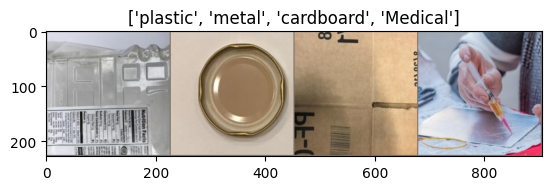

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### **Sample images and their Predictions during Validation Phase**


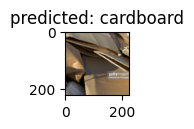

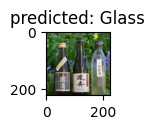

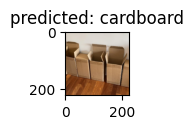

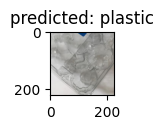

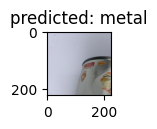

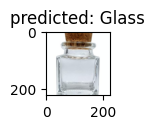

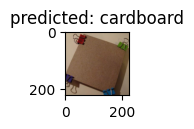

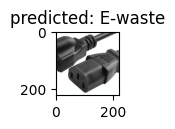

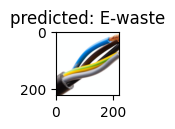

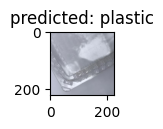

In [ ]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


visualize_model(model_ft)

### **Final Testing of Model Accuracy**


In [ ]:
def test_accuracy(model_ft, testLoader):
    model_ft.eval()
    model_ft.to(device)

    with torch.no_grad():
        accuracy = 0
        for images, labels in iter(testLoader):
            images, labels = images.to(device), labels.to(device)
            output = model_ft.forward(images)
            probabilities = torch.exp(output)
            equality = (labels.data == probabilities.max(dim=1)[1])
            accuracy += equality.type(torch.FloatTensor).mean()
        print("test accuracy:{}".format(accuracy/len(testLoader)*100))


test_accuracy(model_ft, testLoader)

test accuracy:69.33333587646484


### **Conclusion**

-   In this project, even after training the model rigourously, it could not perform well and has an accuracy of only 69.33%.
-   It was noted that the training accuracy was above 85% for most epochs and the validation accuracy was above 80%.
-   Hence, it can be concluded that there is OVERFITTING in the model and measures should be taken to improve the accuracy.


### **Other Results**

-   **Training with 10 Epochs:** Model accuracy was 69.55%
-   **Training with 25 Epochs:** Model accuracy was 75%
